In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize = (9,3)
else:
    figsize = (13,4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = '/app/data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = nab.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Build a cost model
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Compute the maximum over the training set
trmax = data[data.index < train_end]['value'].max()
# Normalize
data['value'] = data['value'] / trmax
# Separate the training data
data_tr = data[data.index < train_end]

# Apply a sliding window
wdata = nab.sliding_window_1D(data, wlen=48)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Time Indexed Models

## Spotting the Problem

**Our KDE estimator is learning from all the training data**

This means it will learn from both these series:

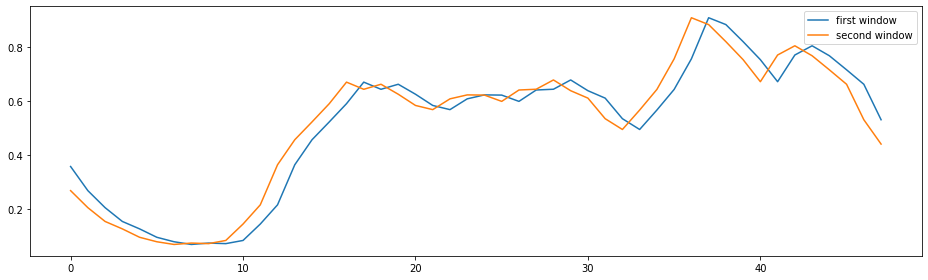

In [5]:
plt.figure(figsize=figsize)
plt.plot(wdata.iloc[0], label='first window')
plt.plot(wdata.iloc[1], label='second window')
plt.legend()
plt.tight_layout()

## Spotting the Problem

**Let us consider the first two window applications**

* In the first window, the observations are $x_0, x_1$ and so on
* In the second window, the observations are $x_1, x_2$ and so on

$x_0$ is number of taxis as 00:00, $x_1$ at 00:30, and so on

* Hence, the first observation in the first window corresponds to 00:00
* ...But in the second window corresponds to 00:30

**Our estimator learns a distribution for the _observations_:**

* Moving the window forward changes "who is who"
* We learn the distribution of $x_0$ (and its correlations) _multiple times_!

The learning problem is still well defined, but also _very complex_

**We will see how to improve things by adding _time information_**

## Exploiting Time

**We have mentioned _two ways to exploit time information_ in KDE:**

The first approach consists in making time (of the day) _an additional variable_:

* Say $\bf x$ is the vector of our observations and $z$ is the time
* Then we learn an estimator for $P({\bf x}, z)$ and one for $P(z)$
* So that we can compute $P({\bf x} \mid z) = P({\bf x}, z) / P(z)$

In our case $P(z)$ is trivial (uniform)

**This is what we did in the previous lecture:**

* We managed to use the time information
* ...But we had to _add one dimension_


**This makes the estimation problem _more complex_**

* ...And we are having enough trouble as it is

## Exploiting Time

**We have discussed two ways to exploit time information in KDE:**

The second approach consists in _learning many KDE estimators_:

* Each KDE estimator is _specialized for a given time_ (e.g. 00:00, 00:30, 01:00...)
* In other words: our estimator becomes an _ensemble_
* Whole estimation = time-based switch + time-specialized KDE

**Let us see the properties of this approach**

* The whole model is _more complex_ and the approach requires _discrete time_
* Each KDE estimator works with _smaller amounts of data_
* ...But the individual density estimation problems are _easier_!

**Let us investigate this approach**

## Learning a 23:30 Estimator

**Let us make a test by learning an estimator for 23:30**

First, we separate the training data:

In [6]:
wdata_tr = wdata[wdata.index < train_end]
wdata_tr.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-07-01 23:30:00,0.357028,0.267573,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,...,0.883252,0.819939,0.753136,0.671452,0.770454,0.804629,0.767721,0.715537,0.661904,0.530438
2014-07-02 00:00:00,0.267573,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804,...,0.819939,0.753136,0.671452,0.770454,0.804629,0.767721,0.715537,0.661904,0.530438,0.440194
2014-07-02 00:30:00,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804,0.143680,...,0.753136,0.671452,0.770454,0.804629,0.767721,0.715537,0.661904,0.530438,0.440194,0.327429
2014-07-02 01:00:00,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804,0.143680,0.214862,...,0.671452,0.770454,0.804629,0.767721,0.715537,0.661904,0.530438,0.440194,0.327429,0.249267
2014-07-02 01:30:00,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804,0.143680,0.214862,0.363448,...,0.770454,0.804629,0.767721,0.715537,0.661904,0.530438,0.440194,0.327429,0.249267,0.194811


## Learning a 23:30 Estimator


**Let us make a test by learning an estimator for 23:30**

Then, we focus on sequences corresponding to 23:30

In [7]:
wdata_tr_2330 = wdata_tr.iloc[0::48]
wdata_tr_2330.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-07-01 23:30:00,0.357028,0.267573,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,...,0.883252,0.819939,0.753136,0.671452,0.770454,0.804629,0.767721,0.715537,0.661904,0.530438
2014-07-02 23:30:00,0.440194,0.327429,0.249267,0.194811,0.158694,0.119646,0.098541,0.083462,0.084615,0.081816,...,0.819379,0.884733,0.724624,0.601159,0.686267,0.743292,0.737530,0.627399,0.576762,0.503967
2014-07-03 23:30:00,0.416357,0.347743,0.277088,0.233694,0.191815,0.144306,0.107661,0.097060,0.103579,0.101307,...,0.987225,0.707898,0.746848,0.730517,0.746156,0.644421,0.564185,0.546736,0.532249,0.527442
2014-07-04 23:30:00,0.513318,0.473941,0.412702,0.373391,0.328581,0.276693,0.237053,0.216574,0.186251,0.147302,...,0.493827,0.476970,0.474599,0.454219,0.462121,0.461627,0.513384,0.546176,0.592105,0.593784
2014-07-05 23:30:00,0.578672,0.533006,0.475455,0.412702,0.362361,0.301287,0.263721,0.233629,0.210944,0.145557,...,0.598624,0.555131,0.465545,0.476640,0.503506,0.508906,0.528364,0.575412,0.539657,0.559905


## Learning a 23:30 Estimator

**Then we proceed as usual**

We choose a bandwidth:

In [8]:
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                      {'bandwidth': np.linspace(0.01, 0.1, 20)}, cv = 5)
grid.fit(wdata_tr_2330)
grid.best_params_

{'bandwidth': 0.03368421052631579}

...And we train the estimator:

In [9]:
h = grid.best_params_['bandwidth']
kde_2330 = KernelDensity(kernel='gaussian', bandwidth=h)
kde_2330.fit(wdata_tr_2330);

* We just need to repeat this for each (meaningful) time value

## Learning the Ensemble

**In our case, all unique hour values are meaningful**

In [10]:
day_hours = wdata_tr.index.hour + wdata_tr.index.minute / 60
day_hours = day_hours.unique()
print(day_hours)

Float64Index([23.5,  0.0,  0.5,  1.0,  1.5,  2.0,  2.5,  3.0,  3.5,  4.0,  4.5,
               5.0,  5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0,
              10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5,
              16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0,
              21.5, 22.0, 22.5, 23.0],
             dtype='float64', name='timestamp')


* `unique` in pandas returns a `Series` with all unique values
* It does not matter how we measure time
* ...We only care about having 48 discrete steps

## Learning the Ensemble

**Then we learn 48 specialized estimators**

In [11]:
kde = {}
for hidx, hour in enumerate(day_hours):
    tmp_data = wdata_tr.iloc[hidx::48]
    kde[hour] = KernelDensity(kernel='gaussian', bandwidth=h)
    kde[hour].fit(tmp_data)

* For each unique time value, we separate a subset of the _training_ data
* Then we build and learn a KDE estimator

**We chose to store everything in a dictionary:**

In [12]:
print(str(kde)[:256], '...}')

{23.5: KernelDensity(bandwidth=0.03368421052631579), 0.0: KernelDensity(bandwidth=0.03368421052631579), 0.5: KernelDensity(bandwidth=0.03368421052631579), 1.0: KernelDensity(bandwidth=0.03368421052631579), 1.5: KernelDensity(bandwidth=0.03368421052631579), ...}


## Generating the Signal

**The we can generate the alarm signal**

* In a practical implementation we should do this step by step
* ...But for an evaluation purpose it is easier to do it all at once

In [13]:
ldens_list = []
for hidx, hour in enumerate(day_hours):
    tmp_data = wdata.iloc[hidx::48]
    tmp_ldens = kde[hour].score_samples(tmp_data)
    tmp_ldens = pd.Series(index=tmp_data.index, data=tmp_ldens)
    ldens_list.append(tmp_ldens)

* For each unique time value, we separate a subset of the _whole_ data
* Then we obtain the estimated (log) probabilities

The process is faster than before!

* ...Because each KDE estimator is trained a smaller dataset

## Generating the Signal

**All signals are stored in a list**

* We need to concatenate them all in single `DataFrame`
* Then we can sort all rows by timestamp (it's the index)

In [14]:
ldens = pd.concat(ldens_list, axis=0)
ldens = ldens.sort_index()
signal = -ldens
signal.head()

timestamp
2014-07-01 23:30:00   -113.900870
2014-07-02 00:00:00   -113.909604
2014-07-02 00:30:00   -113.909604
2014-07-02 01:00:00   -113.909604
2014-07-02 01:30:00   -113.909604
dtype: float64

**A suggestion: always do concatenations in a single step in `pandas`**

It's way faster than appending `DataFrame` objects one by one

## Generating the Signal

**Now we can plot out signal:**

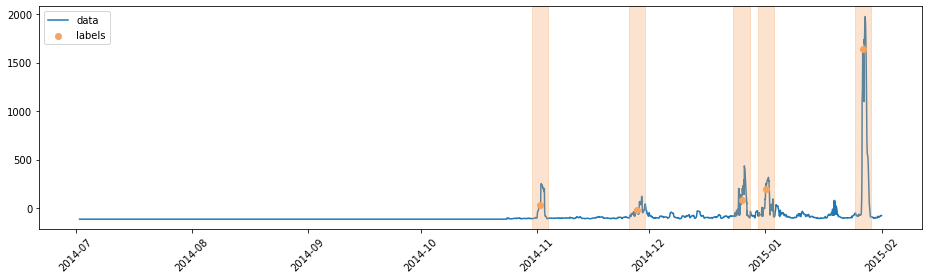

In [15]:
nab.plot_series(signal, labels=labels, windows=windows, figsize=figsize)

It's way more stable than before!

## Effect of the Threshold

**Now, as usual, we examine the response surface**

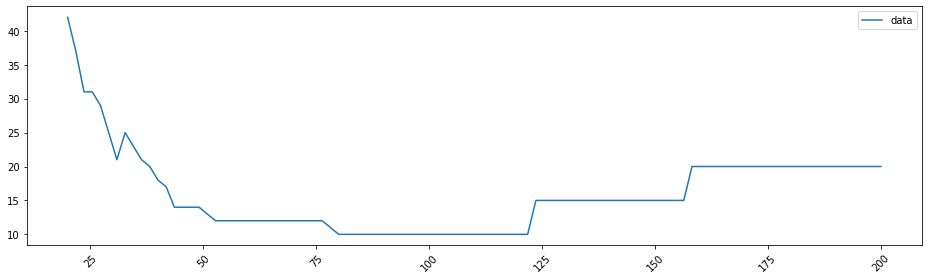

In [16]:
thr_range = np.linspace(20, 200, 100)
cost_range = [cmodel.cost(signal, labels, windows, thr)
              for thr in thr_range]
cost_range = pd.Series(index=thr_range, data=cost_range)
nab.plot_series(cost_range, figsize=figsize)

## Threshold Optimization

**Then we optimize the threshold:**

In [17]:
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]

best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 43.63636363636364, corresponding cost: 10


Let us see the cost on the whole dataset:

In [18]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 14


## Considerations

**Some considerations and take-home messages**

Be mindful of trade-offs

* We wanted to exploit some new information, and we had to choose between:
  - Using all data, but complicating the learning problem
  - Loosing some data, but simplifying the learning problem
* We chose the latter, but perhaps even the other approach had a chance!

Careful with time-dependent models

* Using raw, absolute, time as a feature may lead to _overfitting_
* ...Since every sample has its own time
* So, exploiting time relies on the existend ot meaningful _periods_